In [1]:
import pandas as pd
import numpy as np
import functools
from tensorflow import keras
from tensorflow.keras import utils
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import gc
import pickle

In [2]:
data = pd.read_excel(r'/home/sudarsun/projects/mldl/Sudar_sir_claims_scrubber_data_historical_v1.xlsx')

In [3]:
data.columns

Index(['claim_id', 'patient_id', 'payer_id', 'plan_name', 'denial_code',
       'code_activity', 'activity_desc', 'type_activity', 'act_type_dsc',
       'pdx', 'sdx', 'Reason_for_visit', 'consolidated_diagnoses'],
      dtype='object')

In [4]:
nrecords = len(data)

In [5]:
# we are strongly assuming that the data is not multi-label.
# get the unique cpt codes
cpt = pd.unique(list(data["code_activity"]))
print("unique CPT codes ->", cpt)
print("# unique CPTs: ", len(cpt))

unique CPT codes -> [76700 99283 'I88-4273-03444-01' ... 82384 'C15-1794-00146-01' 73706]
# unique CPTs:  1574


In [6]:
#clear previously owned
if "pdx_icds" in locals():
    # release the memory blocks
    del(pdx_icds)
    del(sdx_icds)
    del(rov_icds)
    gc.collect()
    
# collect the icd codes from the diagnosis columns
pdx_icds = [str(code).split(',') for code in data[data["pdx"].notna()]["pdx"]]
sdx_icds = [str(code).split(',') for code in data[data["sdx"].notna()]["sdx"]] 
rov_icds = [str(code).split(',') for code in data[data["Reason_for_visit"].notna()]["Reason_for_visit"]]

In [7]:
# collect the pdx items
pdx = []
for row in pdx_icds:
    for code in row:
        pdx.append(code)
# collect the sdx items
sdx = []
for row in sdx_icds:
    for code in row:
        sdx.append(code)
# collect the rov items        
rov = []
for row in rov_icds:
    for code in row:
        rov.append(code)

In [8]:
# get rid of NaN from the labels.
dd = data["denial_code"].isna()
for p in range(len(dd)):
    if dd[p]:
        data["denial_code"][p] = "PASS"
        
denial_codes = pd.unique(data["denial_code"])
print("labels found", denial_codes)

<ipython-input-8-9288d9ae17cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["denial_code"][p] = "PASS"


labels found ['PASS' 'MNEC-004' 'PRCE-010' 'PRCE-002' 'CLAI-012' 'MNEC-005' 'CODE-010'
 'DUPL-002' 'PRCE-001' 'PRCE-006' 'CODE-014' 'AUTH-001' 'AUTH-003'
 'CLAI-016' 'PRCE-007' 'NCOV-003' 'NCOV-001' 'AUTH-005' 'ELIG-005'
 'ELIG-001' 'ELIG-007' 'ELIG-006' 'CLAI-008' 'MNEC-003' 'AUTH-004'
 'NCOV-0026' 'TIME-001' 'BENX-002' 'COPY-001' 'BENX-005' 'CLAI-018'
 'DUPL-001']


In [9]:
# get the unique ICD codes.
icd = pd.unique(pdx + sdx + rov)
print("unique icd codes ->", icd)
print("# unique icds: ", len(icd))

unique icd codes -> ['R10.84' 'K76.0' 'M25.562' ... 'S80.811D' 'K25.3' 'T24.012A']
# unique icds:  7388


In [10]:
# forward and reverse index the unique codes.
icd_indices = dict((i,c) for c,i in enumerate(icd))
cpt_indices = dict((str(c),i) for i, c in enumerate(cpt))
denial_indices = dict((str(c),i) for i, c in enumerate(denial_codes))

In [11]:
denial_indices

{'PASS': 0,
 'MNEC-004': 1,
 'PRCE-010': 2,
 'PRCE-002': 3,
 'CLAI-012': 4,
 'MNEC-005': 5,
 'CODE-010': 6,
 'DUPL-002': 7,
 'PRCE-001': 8,
 'PRCE-006': 9,
 'CODE-014': 10,
 'AUTH-001': 11,
 'AUTH-003': 12,
 'CLAI-016': 13,
 'PRCE-007': 14,
 'NCOV-003': 15,
 'NCOV-001': 16,
 'AUTH-005': 17,
 'ELIG-005': 18,
 'ELIG-001': 19,
 'ELIG-007': 20,
 'ELIG-006': 21,
 'CLAI-008': 22,
 'MNEC-003': 23,
 'AUTH-004': 24,
 'NCOV-0026': 25,
 'TIME-001': 26,
 'BENX-002': 27,
 'COPY-001': 28,
 'BENX-005': 29,
 'CLAI-018': 30,
 'DUPL-001': 31}

In [12]:
def encode_column(coldata, index):
    encoded = []
    for r in coldata:
        # check for nan by doing this comparison.
        if r != r:
            encoded.append([])
        else:
            codes = list(map(lambda x: index[x], str(r).split(",")))
            encoded.append(codes)
    return encoded

In [13]:
# encode the claim result
claim_status = data["denial_code"].notna()
#let's first compute the class prior
#prior = claim_status.value_counts(normalize=True)
prior = data["denial_code"].value_counts(dropna=False, normalize=True)

print(prior)

PASS         0.781381
MNEC-004     0.167502
PRCE-002     0.012113
PRCE-001     0.011927
CODE-010     0.006631
MNEC-005     0.006358
CLAI-012     0.002983
NCOV-0026    0.002478
DUPL-002     0.002307
PRCE-006     0.000994
COPY-001     0.000653
NCOV-001     0.000550
AUTH-001     0.000503
PRCE-010     0.000467
CODE-014     0.000400
ELIG-006     0.000353
NCOV-003     0.000348
ELIG-001     0.000343
PRCE-007     0.000304
TIME-001     0.000291
CLAI-008     0.000191
ELIG-007     0.000189
AUTH-003     0.000171
CLAI-016     0.000101
BENX-002     0.000096
BENX-005     0.000093
AUTH-005     0.000082
ELIG-005     0.000070
MNEC-003     0.000069
AUTH-004     0.000047
DUPL-001     0.000003
CLAI-018     0.000002
Name: denial_code, dtype: float64


In [14]:
# let's split the train and test datasets from the input.
proportion = 0.8
train_size = int(nrecords * 0.8)

# generate a random permutation of the indicces
p_index = np.random.permutation(nrecords)

# identify the items for training and hold out.
tr_index = dict((k,i) for (i,k) in enumerate(p_index[0:train_size]))
te_index = dict((k,i) for (i,k) in enumerate(p_index[train_size:]))


In [15]:
# set the required testing data prior
#test_prior = {False:0.5, True:0.5}
test_prior = prior

# override the train prior if needed
train_prior = prior
#train_prior = {False:0.5, True:0.5}

In [16]:
train_prior

PASS         0.781381
MNEC-004     0.167502
PRCE-002     0.012113
PRCE-001     0.011927
CODE-010     0.006631
MNEC-005     0.006358
CLAI-012     0.002983
NCOV-0026    0.002478
DUPL-002     0.002307
PRCE-006     0.000994
COPY-001     0.000653
NCOV-001     0.000550
AUTH-001     0.000503
PRCE-010     0.000467
CODE-014     0.000400
ELIG-006     0.000353
NCOV-003     0.000348
ELIG-001     0.000343
PRCE-007     0.000304
TIME-001     0.000291
CLAI-008     0.000191
ELIG-007     0.000189
AUTH-003     0.000171
CLAI-016     0.000101
BENX-002     0.000096
BENX-005     0.000093
AUTH-005     0.000082
ELIG-005     0.000070
MNEC-003     0.000069
AUTH-004     0.000047
DUPL-001     0.000003
CLAI-018     0.000002
Name: denial_code, dtype: float64

In [17]:
# set the number of required training & testing sample sizes
ntrain = 20000
ntest = 5000

In [18]:
# now collect the ids for training and testing samples.
train_ids = []    
test_ids = []

cum_train = 0
cum_test = 0
# now, we have to draw the sample from tr_indexed data points, hopefully following the class prior.
for c in prior.keys():
    # get the required training data count
    req_ntrain = int(train_prior[c] * ntrain)
    req_ntest = int(test_prior[c] * ntest)
    
    # get the keys from the data
    keys = data[data["denial_code"]==c]["denial_code"].keys()
    print(c, "--> available points:", len(keys), "required train points,", req_ntrain, "test points:", req_ntest)
    #print("required", req_ntrain, "train points from class", c)
    #print("required", req_ntest, "test points from class", c)
    #print("available", len(keys), "points from class", c)
    for k in keys:
        if k in tr_index and len(train_ids)-cum_train < req_ntrain:
            train_ids.append(k)
        if k in te_index and len(test_ids)-cum_test < req_ntest:
            test_ids.append(k)
    print("got", len(train_ids)-cum_train, "train &", len(test_ids)-cum_test, "test points.")
    cum_train = len(train_ids)
    cum_test = len(test_ids)

PASS --> available points: 478574 required train points, 15627 test points: 3906
got 15627 train & 3906 test points.
MNEC-004 --> available points: 102590 required train points, 3350 test points: 837
got 3350 train & 837 test points.
PRCE-002 --> available points: 7419 required train points, 242 test points: 60
got 242 train & 60 test points.
PRCE-001 --> available points: 7305 required train points, 238 test points: 59
got 238 train & 59 test points.
CODE-010 --> available points: 4061 required train points, 132 test points: 33
got 132 train & 33 test points.
MNEC-005 --> available points: 3894 required train points, 127 test points: 31
got 127 train & 31 test points.
CLAI-012 --> available points: 1827 required train points, 59 test points: 14
got 59 train & 14 test points.
NCOV-0026 --> available points: 1518 required train points, 49 test points: 12
got 49 train & 12 test points.
DUPL-002 --> available points: 1413 required train points, 46 test points: 11
got 46 train & 11 test po

In [19]:
#encode the PDX column
pdx_encoded_tr = encode_column(data["pdx"][train_ids], icd_indices)
pdx_encoded_te = encode_column(data["pdx"][test_ids], icd_indices)

In [20]:
#encode the SDX column
sdx_encoded_tr = encode_column(data["sdx"][train_ids], icd_indices)
sdx_encoded_te = encode_column(data["sdx"][test_ids], icd_indices)

In [21]:
# encode the ROV column
rov_encoded_tr = encode_column(data["Reason_for_visit"][train_ids], icd_indices)
rov_encoded_te = encode_column(data["Reason_for_visit"][test_ids], icd_indices)

In [22]:
# encode the CPT column
cpt_encoded_tr = encode_column(data["code_activity"][train_ids], cpt_indices)
cpt_encoded_te = encode_column(data["code_activity"][test_ids], cpt_indices)

In [23]:
def transform_denial_code(c, denial_index):
    if c != c:
        return 0
    return denial_index[c]

In [24]:
# encode the denial column
denial_encoded_tr = list(map(lambda x: transform_denial_code(x, denial_indices), data["denial_code"][train_ids]))
denial_encoded_te = list(map(lambda x: transform_denial_code(x, denial_indices), data["denial_code"][test_ids]))

In [25]:
# get the output column ready
y_train = list(claim_status[train_ids])
y_test = list(claim_status[test_ids])

In [26]:
def one_hot(record, num_classes):
    encoded = np.zeros(num_classes)
    for r in record:
        encoded[r] = 1.
    return encoded

In [27]:
def one_hot_encode(index, multilabel):
    encoded = np.zeros(len(index))
    for label in multilabel:
        print(label)
        if label in index:
            print(index[label])
            encoded[index[label]] = 1.
    return encoded

In [28]:
# free up the space explicitly
if 'X_train' in locals():
    del(X_train) 
    del(X_test)
    gc.collect()

X_train = [np.hstack((one_hot(cpt_encoded_tr[i], num_classes=len(cpt_indices)), 
                      one_hot(rov_encoded_tr[i], num_classes=len(icd_indices)),
                      one_hot(sdx_encoded_tr[i], num_classes=len(icd_indices)),
                      one_hot(pdx_encoded_tr[i], num_classes=len(icd_indices)))) for i in range(len(train_ids))]
X_test  = [np.hstack((one_hot(cpt_encoded_te[i], num_classes=len(cpt_indices)), 
                      one_hot(rov_encoded_te[i], num_classes=len(icd_indices)),
                      one_hot(sdx_encoded_te[i], num_classes=len(icd_indices)),
                      one_hot(pdx_encoded_te[i], num_classes=len(icd_indices)))) for i in range(len(test_ids))]

In [29]:
# free up the space explicitly
if 'features' in locals():
    del(features)
    gc.collect()

features = list(cpt_indices.keys()) + ["ROV-"+k for k in icd_indices.keys()] + ["SDX-"+k for k in icd_indices.keys()] + ["PDX-"+k for k in icd_indices.keys()]
print(len(features))

23738


In [30]:
dt = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
#dt.fit(X_train, y_train)
dt.fit(X_train, denial_encoded_tr)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)

In [50]:
y_pred = dt.predict(X_test)

In [32]:
def print_pr(cm, denial_codes):
    cm = np.array(cm)
    rsum = cm.sum(0)
    csum = cm.sum(1)
    for c in range(len(rsum)):
        cname = denial_codes[c]
        prec = cm[c,c] / csum[c] if csum[c] else 0
        recall = cm[c,c] / rsum[c] if rsum[c] else 0
        
        print(cname, "precision:", round(prec,2), "recall:", round(recall,2))

In [33]:
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(denial_encoded_te, y_pred)
print(cm)

accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print("accuracy = ", accuracy)
#precision_A = cm[0,0]/(cm[0,0]+cm[1,0])
#recall_A = cm[0,0]/(cm[0,0]+cm[0,1])
#precision_B = cm[1,1]/(cm[1,1]+cm[0,1])
#recall_B = cm[1,1]/(cm[1,1]+cm[1,0])
#print("class A: Precision = ", precision_A, " Recall = ", recall_A)
#print("class B: Precision = ", precision_B, " Recall = ", recall_B)

[[3877   24    0    2    0    0    3    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 680  150    0    4    0    0    3    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  12    0    0   48    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  30    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   8   15    0    0    0    0   10    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  11    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  35    0    0    0    0    0    0    0   24    0    0    0    0    0
     0    0    0    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    

In [35]:
print_pr(cm, denial_codes)

PASS precision: 0.99 recall: 0.83
MNEC-004 precision: 0.18 recall: 0.79
PRCE-010 precision: 0.0 recall: 0
PRCE-002 precision: 0.8 recall: 0.89
CLAI-012 precision: 0.0 recall: 0
MNEC-005 precision: 0.0 recall: 0
CODE-010 precision: 0.3 recall: 0.62
DUPL-002 precision: 0.0 recall: 0
PRCE-001 precision: 0.41 recall: 1.0
PRCE-006 precision: 0.0 recall: 0
CODE-014 precision: 0.0 recall: 0
AUTH-001 precision: 0.0 recall: 0
AUTH-003 precision: 0.0 recall: 0
CLAI-016 precision: 0.0 recall: 0
PRCE-007 precision: 0.0 recall: 0
NCOV-003 precision: 0.0 recall: 0
NCOV-001 precision: 0.0 recall: 0
AUTH-005 precision: 0.0 recall: 0
ELIG-005 precision: 0.0 recall: 0
ELIG-001 precision: 0.0 recall: 0


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [37]:
rf = RandomForestClassifier(n_jobs=10)
rf.fit(X_train, denial_encoded_tr)

RandomForestClassifier(n_jobs=10)

In [39]:
yhat = rf.predict(X_test)

In [43]:
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(denial_encoded_te, yhat)
print(cm)

accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print("accuracy = ", accuracy)

[[3778  114    0    3    0    0    2    9    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 408  424    0    2    0    0    1    1    1    0    0    0    0    0
     0    0    0    0    0    0]
 [   1    0    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  24    5    0   31    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  10    1    0    0    3    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  27    3    0    0    0    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  13    9    0    0    0    0   11    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   6    4    0    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  20    1    0    0    0    0    0    0   37    0    0    0    0    0
     1    0    0    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    

In [64]:
print_pr(cm, denial_codes)

PASS precision: 0.97 recall: 0.88
MNEC-004 precision: 0.51 recall: 0.75
PRCE-010 precision: 0.5 recall: 1.0
PRCE-002 precision: 0.52 recall: 0.86
CLAI-012 precision: 0.21 recall: 0.75
MNEC-005 precision: 0.03 recall: 1.0
CODE-010 precision: 0.33 recall: 0.79
DUPL-002 precision: 0.09 recall: 0.09
PRCE-001 precision: 0.63 recall: 0.97
PRCE-006 precision: 0.0 recall: 0
CODE-014 precision: 0.5 recall: 1.0
AUTH-001 precision: 0.0 recall: 0
AUTH-003 precision: 0.0 recall: 0
CLAI-016 precision: 0.0 recall: 0
PRCE-007 precision: 0.5 recall: 0.5
NCOV-003 precision: 0.0 recall: 0
NCOV-001 precision: 0.0 recall: 0
AUTH-005 precision: 0.17 recall: 1.0
ELIG-005 precision: 0.0 recall: 0
ELIG-001 precision: 0.0 recall: 0


In [63]:
print(classification_report(denial_encoded_te, yhat, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3906
           1       0.75      0.51      0.61       837
           2       1.00      0.50      0.67         2
           3       0.86      0.52      0.65        60
           4       0.75      0.21      0.33        14
           5       1.00      0.03      0.06        31
           6       0.79      0.33      0.47        33
           7       0.09      0.09      0.09        11
           8       0.97      0.63      0.76        59
           9       0.00      0.00      0.00         4
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.50      0.50      0.50         2
          19       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          25       1.00    

In [60]:
denial_codes

array(['PASS', 'MNEC-004', 'PRCE-010', 'PRCE-002', 'CLAI-012', 'MNEC-005',
       'CODE-010', 'DUPL-002', 'PRCE-001', 'PRCE-006', 'CODE-014',
       'AUTH-001', 'AUTH-003', 'CLAI-016', 'PRCE-007', 'NCOV-003',
       'NCOV-001', 'AUTH-005', 'ELIG-005', 'ELIG-001', 'ELIG-007',
       'ELIG-006', 'CLAI-008', 'MNEC-003', 'AUTH-004', 'NCOV-0026',
       'TIME-001', 'BENX-002', 'COPY-001', 'BENX-005', 'CLAI-018',
       'DUPL-001'], dtype=object)

[Text(2403.46875, 2075.5636363636363, '82607 <= 0.5\ngini = 0.361\nsamples = 89989\nvalue = [70324, 15075, 42, 1090, 268, 572, 596, 207, 1073, 89\n36, 45, 15, 9, 27, 31, 49, 7, 6, 30, 17, 31\n17, 6, 4, 223, 26, 8, 58, 8]'),
 Text(1933.7740384615386, 1877.8909090909092, '84550 <= 0.5\ngini = 0.345\nsamples = 88141\nvalue = [69895, 14163, 42, 1090, 268, 556, 113, 207, 1066, 89\n36, 45, 15, 9, 27, 31, 49, 7, 6, 30, 17, 30\n17, 6, 4, 223, 26, 8, 58, 8]'),
 Text(1606.9326923076924, 1680.2181818181818, '83735 <= 0.5\ngini = 0.336\nsamples = 87179\nvalue = [69743, 13357, 42, 1090, 268, 554, 113, 207, 1064, 89\n36, 45, 15, 9, 27, 31, 49, 7, 6, 30, 17, 30\n17, 6, 4, 223, 26, 8, 58, 8]'),
 Text(1196.4807692307693, 1482.5454545454545, '85652 <= 0.5\ngini = 0.329\nsamples = 86451\nvalue = [69648, 12725, 42, 1090, 268, 554, 113, 207, 1064, 89\n36, 45, 15, 9, 27, 31, 49, 7, 6, 30, 17, 29\n17, 6, 4, 223, 26, 8, 58, 8]'),
 Text(869.1923076923077, 1284.8727272727274, '82150 <= 0.5\ngini = 0.32\nsamples

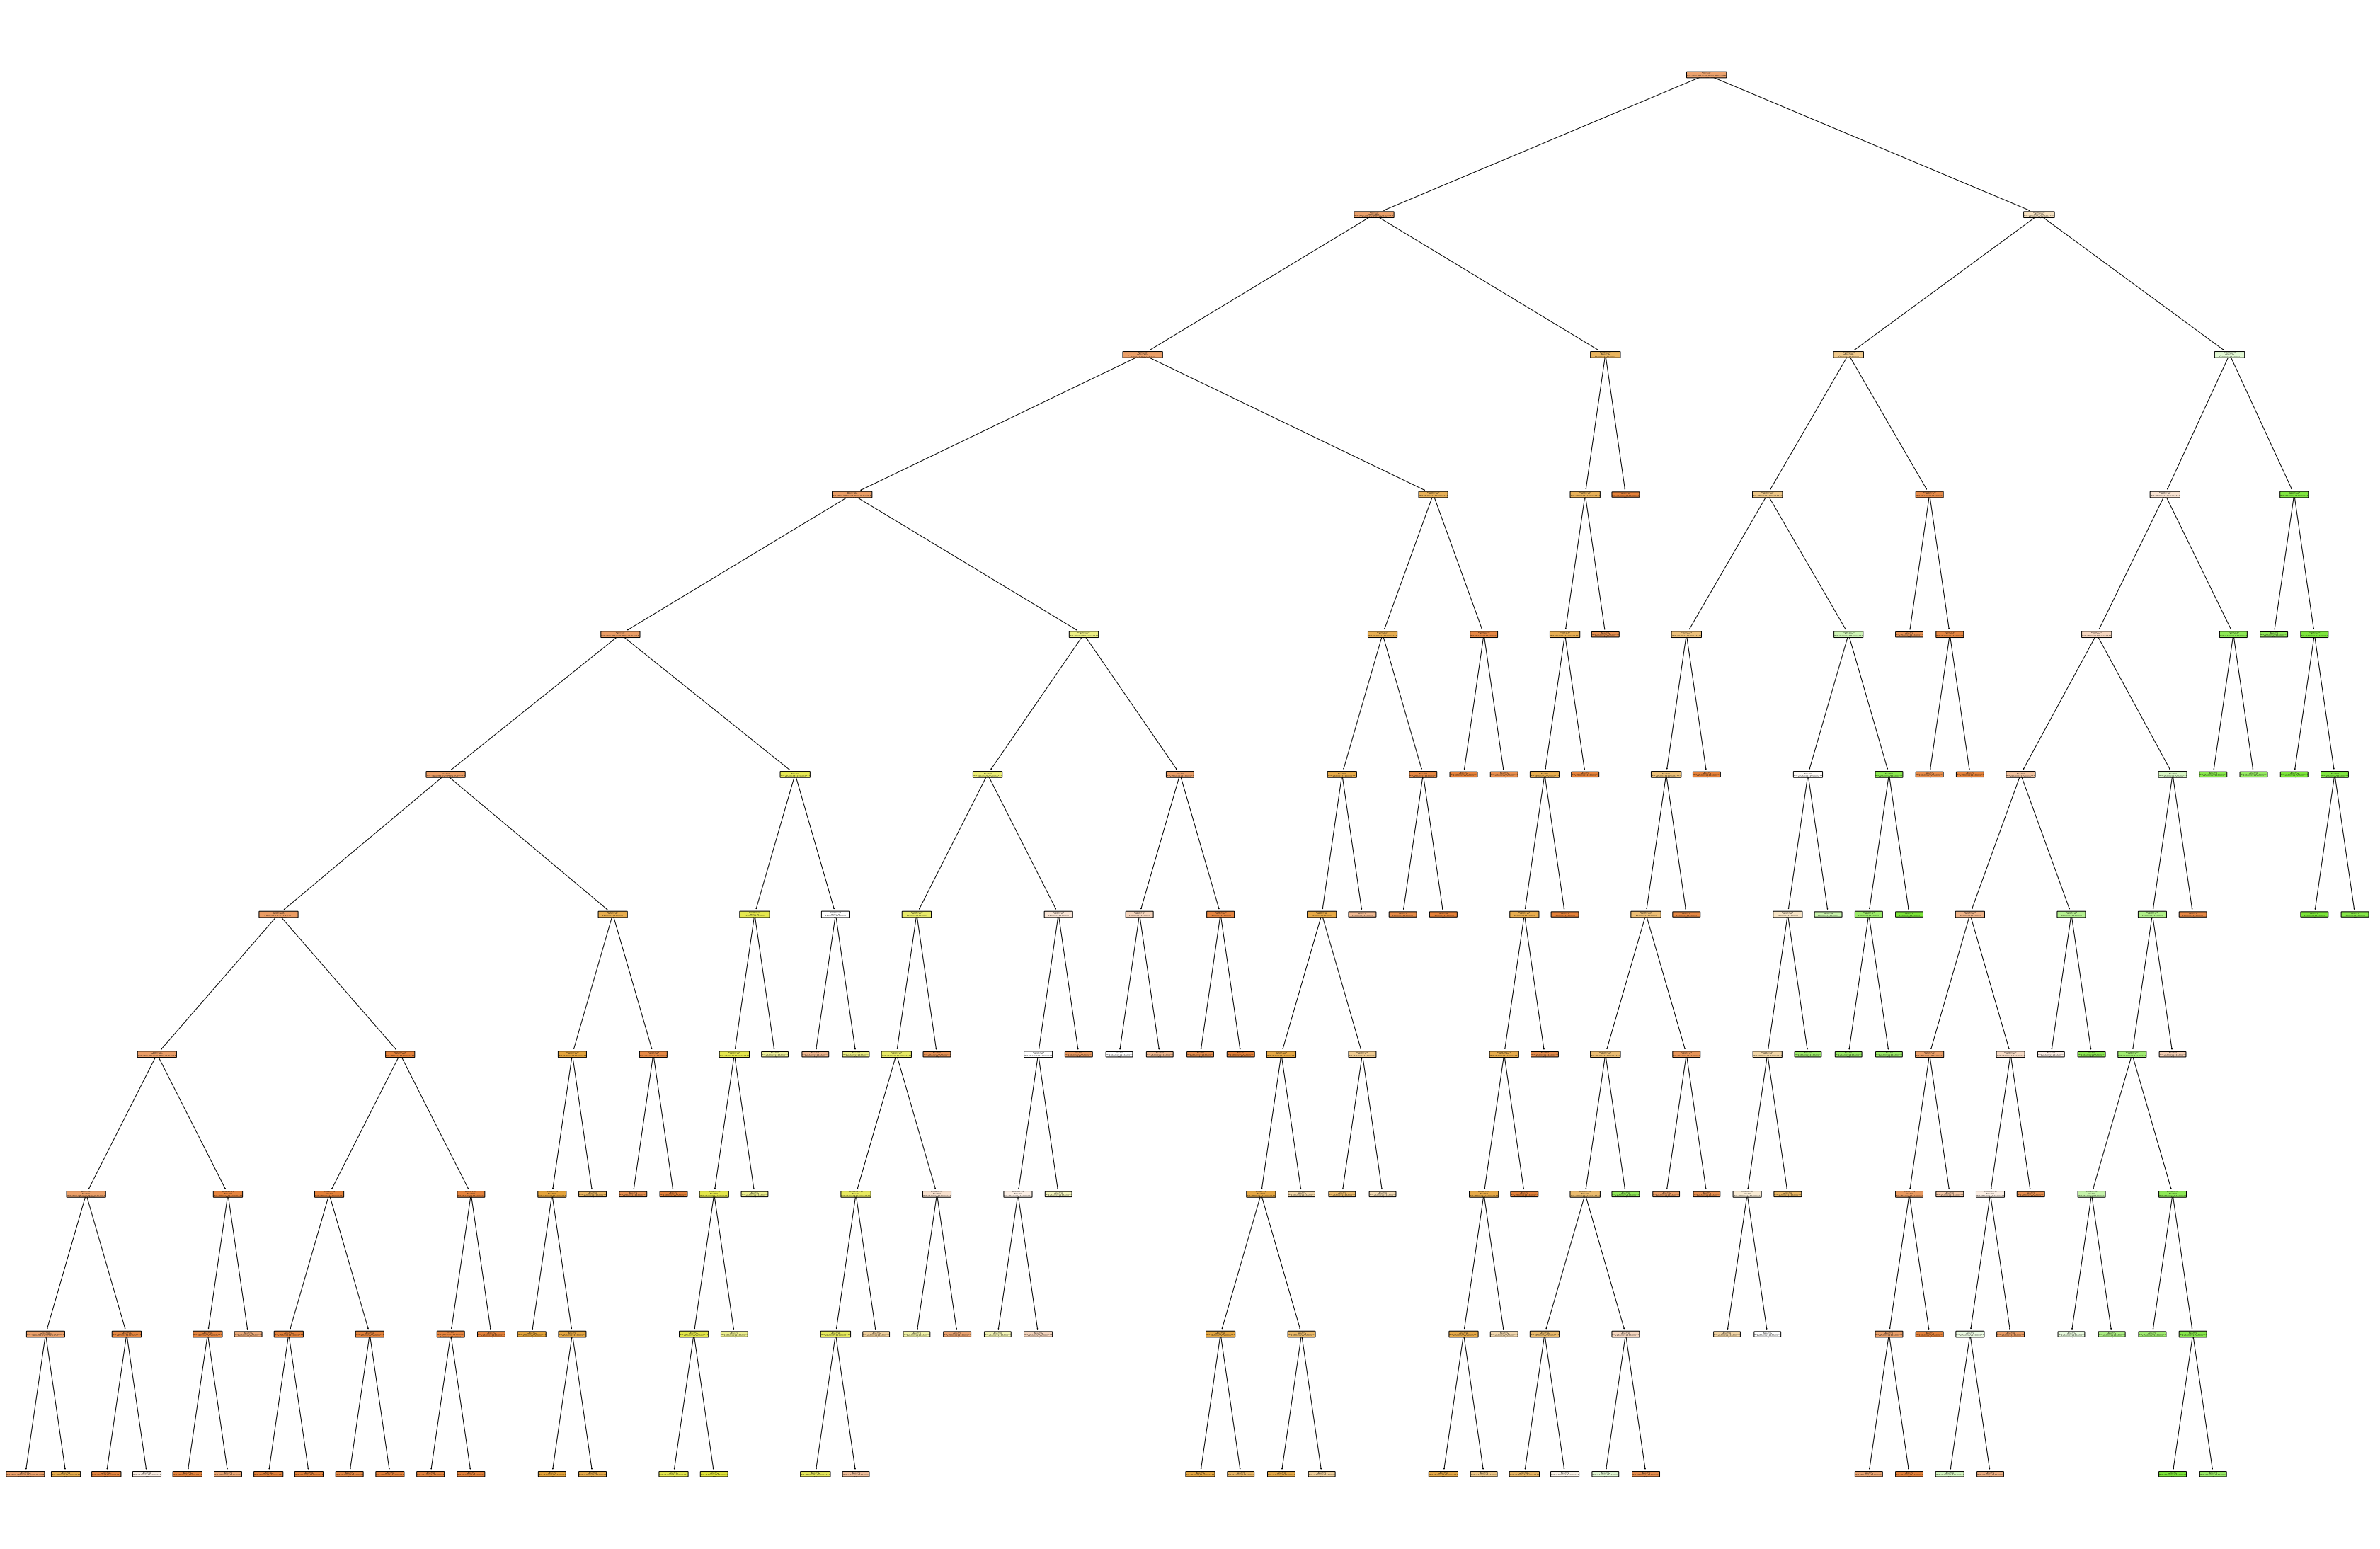

In [35]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(60,40))
plot_tree(dt, filled=True, rounded=True, impurity=True, feature_names=features)

In [36]:
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [37]:
rules = get_rules(dt, features, denial_codes)#list(["True", "False"]))
for r in rules:
    print(r)

if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (85652 <= 0.5) and (82150 <= 0.5) and (84630 <= 0.5) and (SDX-Z99.2 <= 0.5) and (99213 <= 0.5) and (85025 <= 0.5) and (83615 <= 0.5) then class: PASS (proba: 79.11%) | based on 72,155 samples
if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (85652 <= 0.5) and (82150 <= 0.5) and (84630 <= 0.5) and (SDX-Z99.2 <= 0.5) and (99213 <= 0.5) and (85025 > 0.5) and (SDX-H02.413 <= 0.5) then class: PASS (proba: 96.91%) | based on 4,307 samples
if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (85652 <= 0.5) and (82150 <= 0.5) and (84630 <= 0.5) and (SDX-Z99.2 <= 0.5) and (99213 > 0.5) and (PDX-P59.9 <= 0.5) and (SDX-D52.9 <= 0.5) then class: PASS (proba: 97.79%) | based on 4,206 samples
if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (85652 <= 0.5) and (82150 <= 0.5) and (84630 <= 0.5) and (SDX-Z99.2 > 0.5) and (SDX-K21.9 <= 0.5) and (SDX-N18.6 <= 0.5) and (2022-01-14 00:00:00 <= 0.5) then class: PASS (pr